# Waiter Tips Prediction with Machine Learning

# 🧮 Tip Prediction with RandomForest

## Introduction

Tipping is a common practice in restaurants, and predicting the tip amount based on customer and bill characteristics is both an interesting data science exercise and a useful application in real-world scenarios.  

In this project, we use the **famous "Tips" dataset** (originally popularized by Seaborn) to build a machine learning model that estimates the expected tip. The dataset contains information about restaurant bills, including:

- **Total bill** amount  
- **Tip** amount (target variable)  
- **Sex** of the payer  
- **Smoker** status  
- **Day** of the week  
- **Time** (Lunch or Dinner)  
- **Party size** (number of people)  

We enrich the dataset with engineered features, such as:

- **Average bill per person** (`total_bill / size`)  
- **Weekend indicator** (Saturday/Sunday vs. weekdays)  

The target variable is the **tip amount** (continuous value).  

---

## Objective

- Perform **Exploratory Data Analysis (EDA)** to understand the distribution of tips and influencing factors.  
- Build and evaluate a **RandomForest Regressor** to predict tip amounts.  
- Provide an interactive **Streamlit App** that allows users to input custom values (bill, day, party size, etc.) and get a real-time tip prediction.  
- Prepare documentation and results for submission on **Kaggle** and for a **GitHub portfolio project**.  

---

## Why this project?

- It demonstrates the **end-to-end machine learning workflow**:  
  1. Data cleaning & preprocessing  
  2. Feature engineering  
  3. EDA & visualization  
  4. Model training & evaluation  
  5. Deployment as an interactive web app  

- It is a **simple but practical dataset**, making it great for educational purposes, while still allowing creative extensions such as more advanced models (e.g., Gradient Boosting, XGBoost).  

---


<img src='https://www.gastro-academy.com/fileadmin/_processed_/2/7/csm_Tipps-Trinkgeld-Gastronomie_sam-truong-dan-627874-unsplash_83ef7cf8b3.jpg'>

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Excel laden
df = pd.read_excel("tip.xlsx")

## Exploratory Data Analysis (EDA)

Before building the predictive model, we perform an exploratory analysis of the dataset to better understand its structure and main patterns.

The goals of the EDA are:

- **Check missing values and data types**  
- **Understand the distribution of the target variable (`tip`)**  
- **Explore relationships between tip and key features**:  
  - Total bill  
  - Party size  
  - Day of the week  
  - Time (Lunch vs. Dinner)  
  - Smoker status  
  - Sex of the payer  
- **Identify correlations** among numerical features  

We will use summary statistics, histograms, boxplots, and correlation heatmaps to highlight the most important insights.  


In [3]:
# Preview of the dataset
display(df.head())
display(df.info())
display(df.describe())

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


None

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [4]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64


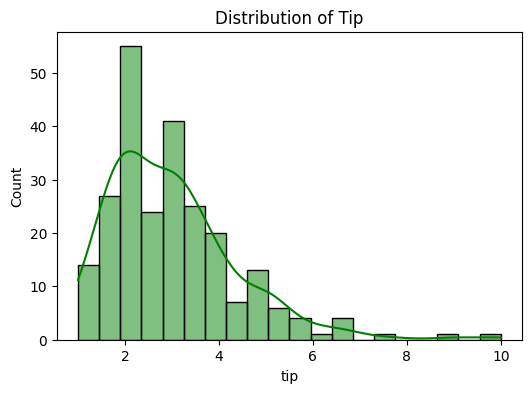

In [5]:
# Distribution of the target variable (tip)
plt.figure(figsize=(6,4))
sns.histplot(df["tip"], kde=True, bins=20, color="green")
plt.title("Distribution of Tip")
plt.show()

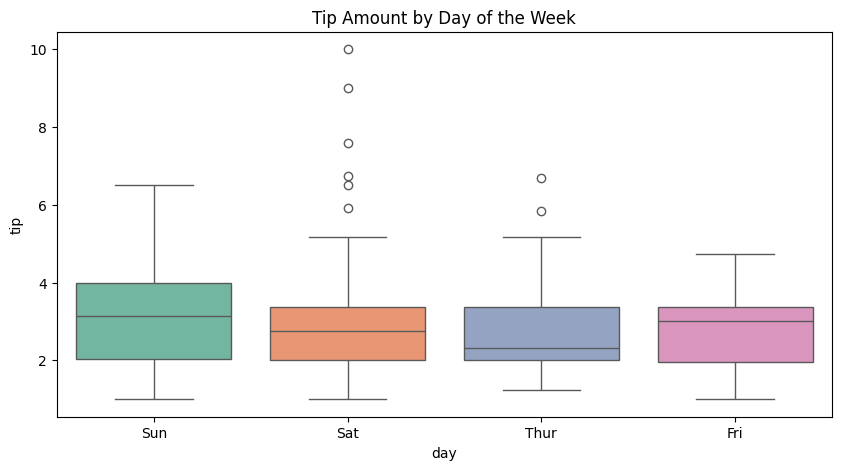

In [6]:
#  Boxplots by categorical features
plt.figure(figsize=(10,5))
sns.boxplot(x="day", y="tip", data=df, palette="Set2")
plt.title("Tip Amount by Day of the Week")
plt.show()

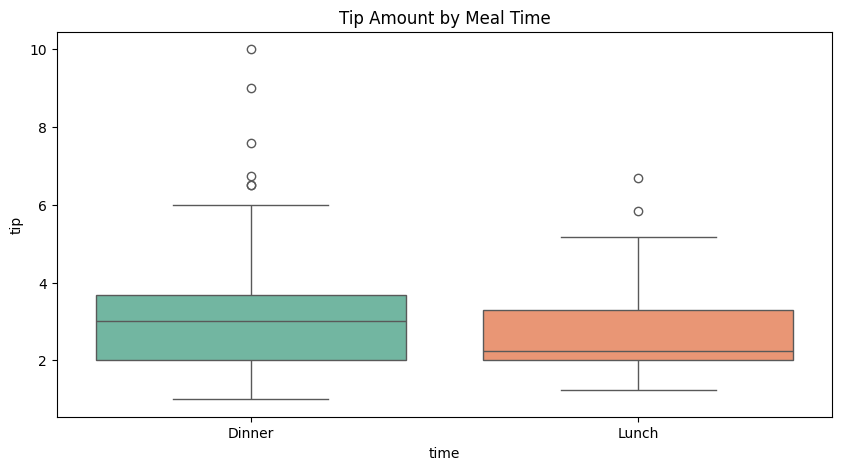

In [7]:

plt.figure(figsize=(10,5))
sns.boxplot(x="time", y="tip", data=df, palette="Set2")
plt.title("Tip Amount by Meal Time")
plt.show()

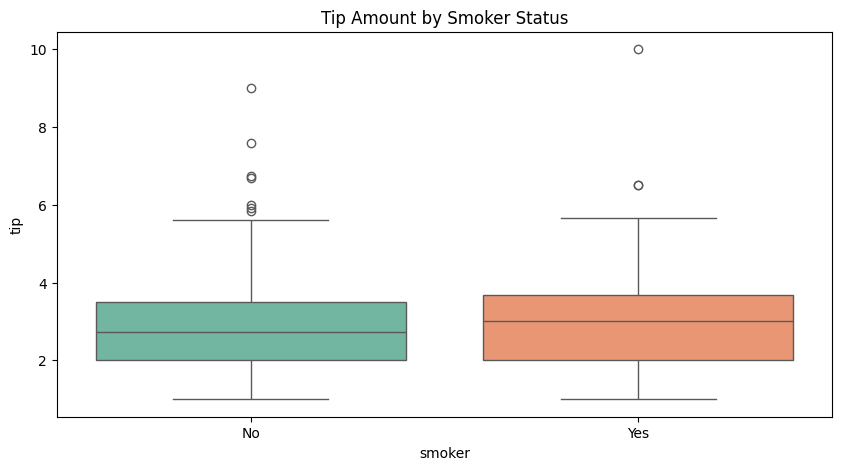

In [8]:
plt.figure(figsize=(10,5))
sns.boxplot(x="smoker", y="tip", hue="smoker", data=df, palette="Set2", legend=False)
plt.title("Tip Amount by Smoker Status")
plt.show()

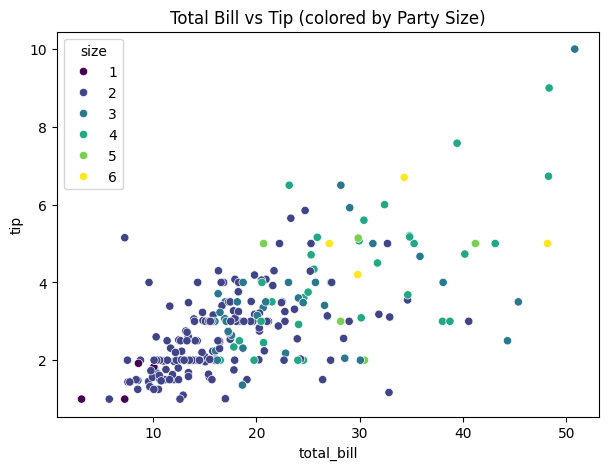

In [9]:
#  Scatterplot: Total Bill vs Tip
plt.figure(figsize=(7,5))
sns.scatterplot(x="total_bill", y="tip", hue="size", data=df, palette="viridis")
plt.title("Total Bill vs Tip (colored by Party Size)")
plt.show()

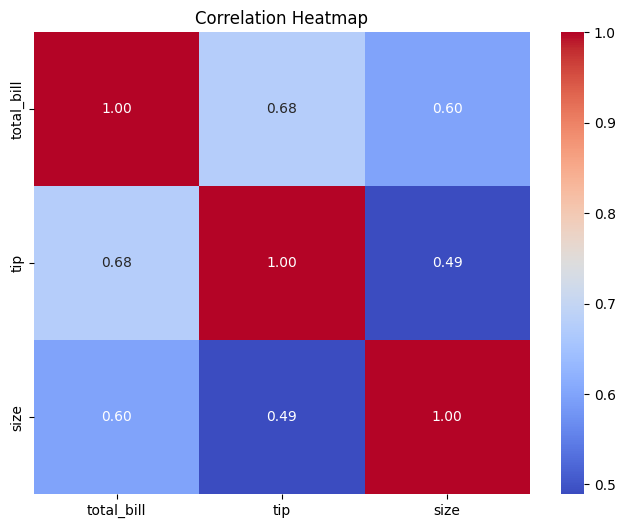

In [10]:
# 6. Correlation heatmap of numerical features
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## Preprocessing & Feature Engineering

To prepare the dataset for modeling, we convert categorical variables into numeric format and create additional features that may improve model performance:

- **Encoding categorical variables**:  
  - `sex` → Female = 0, Male = 1  
  - `smoker` → No = 0, Yes = 1  
  - `day` → Thur = 0, Fri = 1, Sat = 2, Sun = 3  
  - `time` → Lunch = 0, Dinner = 1  

- **Feature engineering**:  
  - `avg_bill_per_person` = total_bill / party size  
  - `weekend` = 1 if day is Saturday or Sunday, else 0  

These transformations ensure the features are numerical and capture meaningful patterns for the regression model.


In [12]:
# Preprocessing
df["sex"]    = df["sex"].map({"Female": 0, "Male": 1})
df["smoker"] = df["smoker"].map({"No": 0, "Yes": 1})
df["day"]    = df["day"].map({"Thur": 0, "Fri": 1, "Sat": 2, "Sun": 3})
df["time"]   = df["time"].map({"Lunch": 0, "Dinner": 1})
df["avg_bill_per_person"] = df["total_bill"] / df["size"].replace(0, np.nan)
df["avg_bill_per_person"] = df["avg_bill_per_person"].fillna(df["total_bill"])
df["weekend"] = df["day"].isin([2, 3]).astype(int)


## Model Training

For the predictive task, we use a **RandomForest Regressor** from scikit-learn.  
This ensemble method is well-suited for tabular data and can capture non-linear relationships between features and the target.

The training process includes:

- Splitting the dataset into training and testing sets  
- Fitting the RandomForest model on the training data  
- Evaluating performance using regression metrics:
  - **MAE** (Mean Absolute Error)  
  - **RMSE** (Root Mean Squared Error)  
  - **R²** (Coefficient of Determination)  

This provides insights into how well the model can generalize to unseen data before deployment.


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Features & Target
X = df[["total_bill","sex","smoker","day","time","size","avg_bill_per_person","weekend"]]
y = df["tip"]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")


MAE:  0.78
RMSE: 0.96
R²:   0.266


In [15]:

# save
joblib.dump(model, "modelML.pkl")
print("✅ Modell gespeichert als modelML.pkl")


✅ Modell gespeichert als modelML.pkl


## Results & Discussion

The RandomForest Regressor was evaluated on the test set with the following metrics:

- **MAE (Mean Absolute Error):** 0.78  
- **RMSE (Root Mean Squared Error):** 0.96  
- **R² (Coefficient of Determination):** 0.266  

**Interpretation:**
- On average, the model’s predictions differ from the true tip values by around **0.78 units**.  
- The RMSE indicates that larger errors are relatively rare but can occur.  
- The R² value of **0.266** suggests that the model explains about **27% of the variance** in the tip amounts.  

**Conclusion:**
- While the RandomForest model captures some patterns (e.g., higher bills leading to higher tips), the relatively low R² shows that tip behavior is also influenced by other unobserved factors (e.g., customer mood, service quality).  
- Still, the model provides a reasonable baseline for tip prediction and demonstrates the full ML workflow (EDA → preprocessing → modeling → deployment).


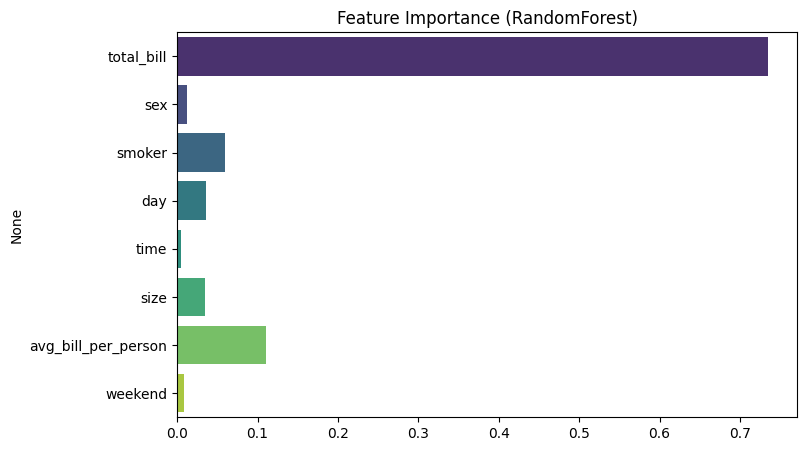

In [16]:
# 1. Feature importance
importances = model.feature_importances_
feat_names = X.columns
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=feat_names, palette="viridis")
plt.title("Feature Importance (RandomForest)")
plt.show()

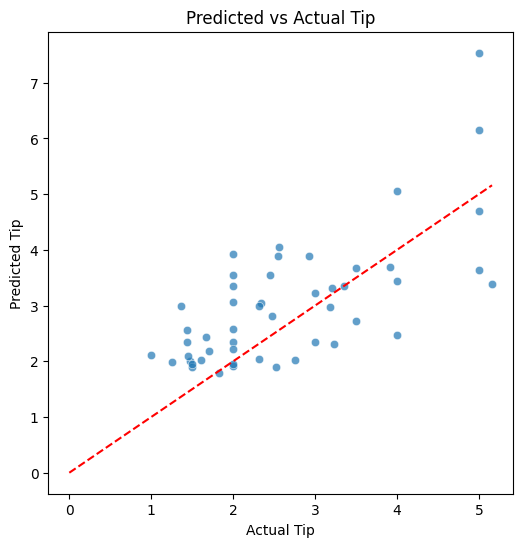

In [17]:
# 2. Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([0, max(y_test)], [0, max(y_test)], color="red", linestyle="--")
plt.xlabel("Actual Tip")
plt.ylabel("Predicted Tip")
plt.title("Predicted vs Actual Tip")
plt.show()


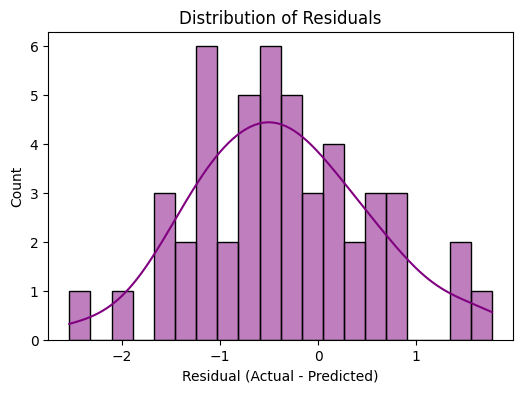

In [18]:
# 3. Residuals
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=20, kde=True, color="purple")
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()